<a href="https://colab.research.google.com/github/MiningTheSkies/GPGN598B_full-waveform-modeling-across-scales/blob/main/GPGN_598B_HW4_Pseudo_Spectral_Method_(1D_wave_eq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Preface

This notebook was put together on Google Colab and makes use of both Google Colab's specific LaTeX formatting/tags (MathJax), as well as Google Colab's 'Forms' feature. Formatting changes in GitHub are manageable but running the simulation not on Google Colab will require hardcoding the values at the approprite blocks.

#### Libraries and Functions

###### Library imports 

In [281]:
# ----- Import Libraries -----
#-----------------------------
# used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import scipy.signal
plt.rcParams['figure.figsize']= [12,6]
plt.rcParams.update({'font.size': 18})

# unused
# import itertools
# from matplotlib import gridspec

##### Functions

In [290]:
def rhsWaveVelocityMult(T0hat_ri, t, k, rho):
    That = T0hat_ri[:Nx] + (1j) * T0hat_ri[Nx:]
    vhat_dt = 1/rho * (1j) * k * That
    vhat_dt_ri = np.concatenate((vhat_dt.real, vhat_dt.imag)).astype('float64')
    return vhat_dt_ri

# def rhsWaveVelocityConv(vhat_ri, k, rho):
#     vhat = vhat_ri[:Nx] + (1j) * vhat_ri[Nx:]
#     d_vhat = 1/rho np.convolve()* (1j) * k * v0hat
#     d_vhat_ri = np.concatenate((d_vhat_ri.real, d_vhat_ri.imag)).astype('float64')
#     return d_vhat_ri

def rhsWaveStress(v0hat_ri, t, k, kappa):
    vhat = v0hat_ri[:Nx] + (1j) * v0hat_ri[Nx:]
    That_dt = kappa * (1j) * k * vhat
    That_dt_ri = np.concatenate((That_dt.real, That_dt.imag)).astype('float64')
    return That_dt_ri

def vectorizeParameter(arr_parameters, arr_shape, arr_dx):
    arr = np.zeros_like(arr_shape)
    for domain_i in range(arr_parameters.shape[0]):       # define the kappa values along the given user-provided domains
        if arr_parameters[domain_i,3] == 0:
            if arr_parameters[domain_i,4] == 0:
                arr[    int(arr_parameters[domain_i,1]/arr_dx +1):  int(arr_parameters[domain_i,2]/arr_dx) -1]  = arr_parameters[domain_i,0]
            elif arr_parameters[domain_i,4] == 1:
                arr[    int(arr_parameters[domain_i,1]/arr_dx +1):  int(arr_parameters[domain_i,2]/arr_dx)   ]  = arr_parameters[domain_i,0]
        elif arr_parameters[domain_i,3] == 1:
            if arr_parameters[domain_i,4] == 0:
                arr[    int(arr_parameters[domain_i,1]/arr_dx   ):  int(arr_parameters[domain_i,2]/arr_dx) -1]  = arr_parameters[domain_i,0]
            elif arr_parameters[domain_i,4] == 1:
                arr[    int(arr_parameters[domain_i,1]/arr_dx   ):  int(arr_parameters[domain_i,2]/arr_dx)   ]  = arr_parameters[domain_i,0]
    return arr

```
Course: GPGN 598B - Full Waveform Modelling Across Scales
Date: March 14, 2020
```
# Homework: Pseudo Spectral Method - 1D Wave Equation
---

## Pseudo Spectral Method
---

The Pseudo Spectral Method, like the Finite Difference Method, is a strong form solution of Partial Differential Equations. Instead of using finite differencing, the Pseudo Spectral Method utilizes Fourier Transform to calculate the approximatation of the spatial derivatives. The Pseudo Spectral Method has very high accuracy when the field to be differentiated is smooth; however, when singulatiries exist, this method suffers from so-called Gibbs Phenomenon.

The Continuous Fourier Transform (CFT) $\hat F(k)$ of any function $f(x) (\int_{-\infty}^\infty |f(x)|dx < \infty)$ and its inverse transform are defined as:

\begin{align}
    \hat{F}(k) &= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^\infty f(x)e^{-ikx}dx \tag{1}\\
    f(x) &= \frac{1}{\sqrt{2\pi}}\int_{-\infty}^\infty \hat{F}(k)e^{ikx}dk \tag{2}
\end{align}

As a consequence, the derivatives of $f(x)$ can be expressed as:

\begin{align}
    \frac d{dx}f(x) &= \frac d{dx}\bigg[\frac 1{\sqrt{2\pi}}\int_{-\infty}^\infty \hat F(k)e^{ikx}dk\bigg] \\
    &= \frac 1{\sqrt{2\pi}}\int_{-\infty}^\infty ik\hat F(k)e^{ikx}dk \tag{3}
\end{align}

Therefore, we can use Fourier Transform to calculate the derivatives of a function $f(x)$, given the Fourier Transform for that function exists.

The steps are simple and clear:

1. Fourier Transform whatever field $f(x)$ we need to differentiate
2. Multiply each Fourier coefficient $\hat F(k)$ by $ik$
3. Carry out inverse Fourier Transform to get desired derivatives

For simplicity, we are going to solve the 1-D wave equation again, using the Pseudo Spectral Method.

## 1) Wave Equation
---

### Given Information

The 1-D expression of the wave equation is:

$$
    \rho(x)\,\partial_t^2u(x,t)=\partial_x[\kappa(x)\,\partial_xu(x,t)], \qquad
    (x\in[0,L],t\in[0,=\infty))
$$

where $u(x,t)$ is the displacement field at the position $x$ at instant $t$, $\rho(x)$ is the material density, and $\kappa(x)$ is the material bulk modulus.

The initial conditions are:

\begin{align}
    u(x,0) &= e^{-0.1(x-50)^2} \\
    \partial_tu(x,0) &= 0
\end{align}



To solve the wave equation, you can recognize that it is equivalent to

\begin{align}
    \rho(x)\,\partial_tv(x,t) &= \partial_xT(x,t) \\
    \partial_tT(x,t) &= \kappa(x)\,\partial_xv(x,t)
\end{align}

where

\begin{align}
    v(x,t) &= \partial_tu(x,t) \qquad & \text{is a velocity} \\
    T(x,t) &= \kappa(x)\,\partial_xu(x,t) \qquad & \text{is a stress}
\end{align}

Write the discretized form of the system to solve for $(v,T)$. The grid size $\Delta x$ is chosen to be $0.1$. The string legnth is $L=100$. Plot your numerical results at several time steps for a homogeneous material case:

- $\rho=1, \kappa=1, \quad (x\in[0,100]) $

### Work

> For simplified notation, $v$ and $T$ are in terms of $(x,t)$; their Fourier Transform representations, $\mathcal{F}(v)=\hat v$ and $\mathcal{F}(T)=\hat T$, are in terms of $(k,t)$; $\kappa$ and $\rho$ are also in terms of $x$; these will be assumed and not written. Partial derivatives will be written as $\partial_xf(x,t)=f_x$.

First, we isolate $v$ and $T$.

\begin{align}
    \rho\,v_t &= T_x \qquad &
    T_t &= \kappa\,v_x
    \\[3pt]
    v_t &= \frac{T_x}{\rho} \qquad &
\end{align}

Now, we rewrite the equations in terms of their Fourier Transform representations. We will use the _Multiplication Property_ of Fourier Transforms, which states that the Fourier Transform of the product of two signals in time is the convolution of the two Fourier Transforms. This property still holds as we take spatial Fourier Transforms.

\begin{align}
    \mathcal{F}(v_t) &= \mathcal{F}\left(\frac{T_x}{\rho}\right) \qquad &
    \mathcal{F}(T_t) &= \mathcal{F}(\kappa \,v_x)
    \\[3pt]

    \mathcal{F}(v_t) &= \mathcal{F}\left(\frac{1}{\rho}\right) * \mathcal{F}(T_x) \qquad &
    \mathcal{F}(T_t) &= \mathcal{F}(\kappa) * \mathcal{F}(v_x)
    \\[3pt]

    \hat v_t &= \frac 1{\hat\rho} * (ik\,\hat T) \qquad &
    \hat T_t &= \hat\kappa * (ik\,\hat v)
    \\[3pt]

    \hat v_t &= ik(\hat T * \hat\rho^{-1}) \qquad &
    \hat T_t &= ik(\hat v * \hat\kappa)
\end{align}

Where $*$ represents convolution.

We will now begin discretizing the equations in order to code and visualize.



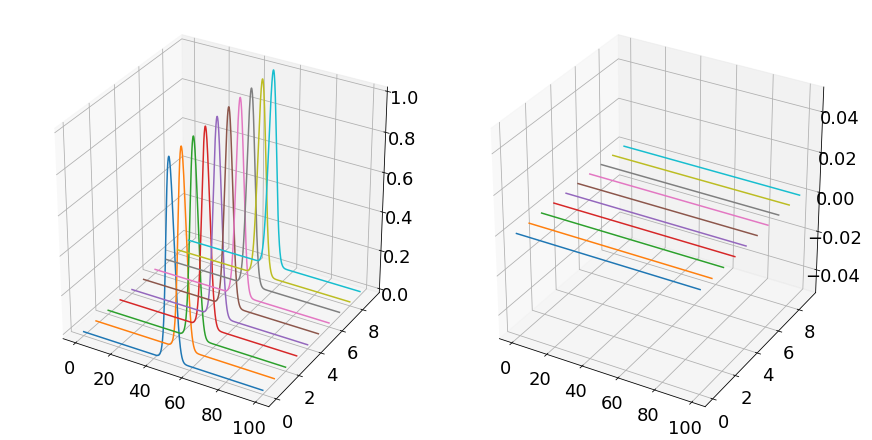

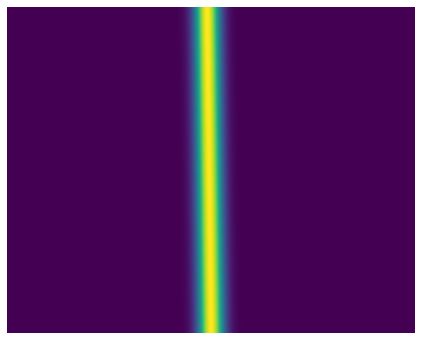

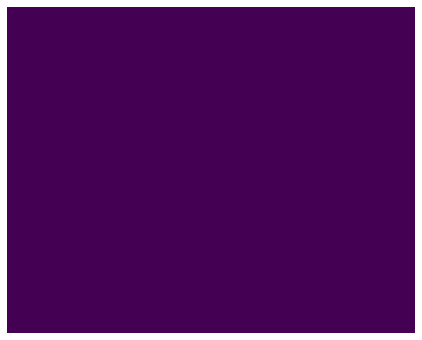

In [296]:
L = 100         # length of the domain
dx = 0.1        # distance between spatial nodes
Nx = int(L/dx)  # number of spatial nodes
rho = 1         # value of density
x = np.arange(0, L, step=dx)    # define x-mesh

# Define the material bulk modulus as a vector
kappa_values = np.array([[1, 0, 100, 1, 1]])       # list as value, domain_start, domain_stop, left & right domain bound inclusivity (0 = exclusive (), 1 = inclusive [])
kappa = vectorizeParameter(kappa_values, x, dx)     # array parameters, array with shape to duplicate, distance between array nodes

# Time definition to be used in Fourier frequency domain
dt = 0.01
Nt = 100
t = np.arange(0, Nt*dt, dt)

# Define discrete wave numbers
k = 2*np.pi*np.fft.fftfreq(Nx, d=dx)

# Initial Conditions
# displacement
u0 = np.exp(-0.1*(x-50)**2)
u0hat = np.fft.fft(u0)
# velocity
v0 = np.zeros_like(x)
v0hat = np.fft.fft(v0)
# stress
T0 = kappa * u0
T0hat = np.fft.fft(T0)

# Due to SciPy's odeint function finickiness with complex numbers, modify u0hat from a (N-element) complex vector to a (2N-element) real vector
v0hat_ri = np.concatenate((v0hat.real, v0hat.imag))
T0hat_ri = np.concatenate((T0hat.real, T0hat.imag))

vhat_dt_ri = odeint(rhsWaveVelocityMult, T0hat_ri, t, args=(k, rho))
That_dt_ri = odeint(rhsWaveStress, v0hat_ri, t, args=(k, kappa))

vhat_dt = vhat_dt_ri[:,:Nx] + (1j) * vhat_dt_ri[:,Nx:]
That_dt = That_dt_ri[:,:Nx] + (1j) * That_dt_ri[:,Nx:]

# Inverse FFT (frequency domain --> spatial domain)
v_dt = np.zeros_like(vhat_dt)
T_dt = np.zeros_like(That_dt)
for i in range(len(t)):
    v_dt[i,:] = np.fft.ifft(vhat_dt[i,:])
    T_dt[i,:] = np.fft.ifft(That_dt[i,:])

v_dt = v_dt.real
T_dt = T_dt.real

fig, axs = plt.subplots(1,2, constrained_layout=True, subplot_kw={'projection':'3d'})
for i in range(v_dt_plot.shape[0]):
    vs = i*np.ones(v_dt_plot.shape[1])
    Ts = i*np.ones(T_dt_plot.shape[1])
    axs[0].plot(x,vs,v_dt_plot[i,:])
    axs[1].plot(x,Ts,T_dt_plot[i,:])
plt.show()

plt.figure()
plt.imshow(np.flipud(v_dt), aspect=8)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(np.flipud(T_dt), aspect=8)
plt.axis('off')
plt.show()

In [277]:
print(np.mean(T0hat_ri), np.mean(v0hat_ri))
print(np.mean(That_dt_ri), np.mean(vhat_dt_ri))
print(np.mean(T_dt), np.mean(v_dt))

3.552713678800502e-17 0.0
0.0 1.5526290653156138e-12
0.0 0.05604991216397929


In [228]:
# print(v0hat[:])

In order to discretize the equations, we must transition from the CFT to a discrete fourier transform (DFT), which will partition the initial continuous wave equation into a sampled approximation in space.

Define base parameters and the initial condition

## 2) Heterogeneous material
---

### Given Information

Use the same code you just wrote and investigate the evolution of the displacement field time series when:

- $\rho=1, \kappa=1, \quad (x\in[0,60]) \quad$ and
- $\rho=1, \kappa=4, \quad (x\in[60,100]) $

### Work

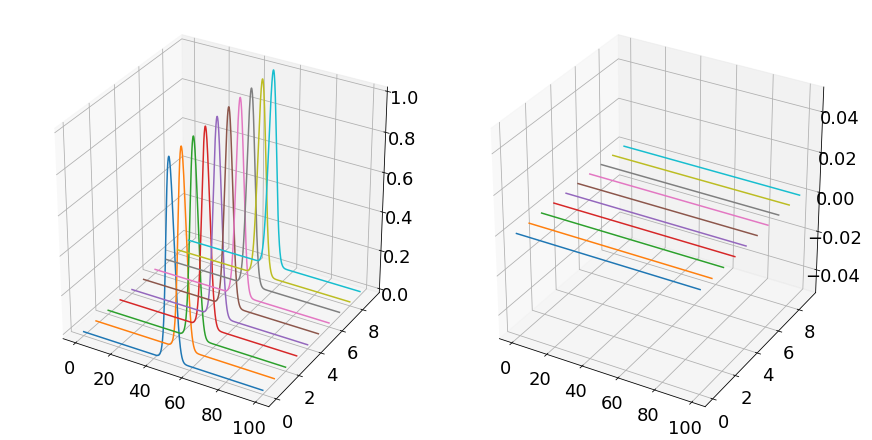

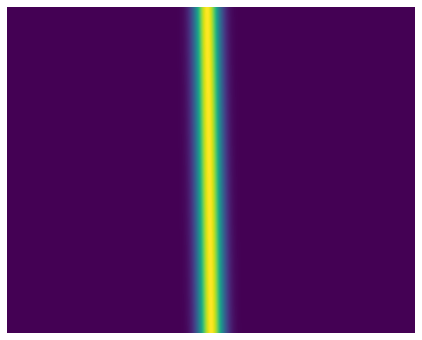

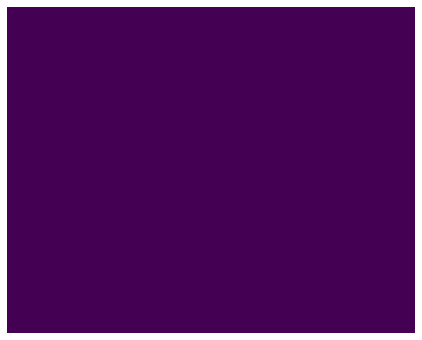

In [291]:
L = 100         # length of the domain
dx = 0.1        # distance between spatial nodes
Nx = int(L/dx)  # number of spatial nodes
rho = 1         # value of density
x = np.arange(0, L, step=dx)    # define x-mesh

# Define the material bulk modulus as a vector
kappa_values = np.array([[1, 0, 60, 1, 1],
                         [4, 60, 100, 0, 1]])       # list as value, domain_start, domain_stop, left & right domain bound inclusivity (0 = exclusive (), 1 = inclusive [])
kappa = vectorizeParameter(kappa_values, x, dx)     # array parameters, array with shape to duplicate, distance between array nodes

# Time definition to be used in Fourier frequency domain
dt = 0.01
Nt = 100
t = np.arange(0, Nt*dt, dt)

# Define discrete wave numbers
k = 2*np.pi*np.fft.fftfreq(Nx, d=dx)

# Initial Conditions
# displacement
u0 = np.exp(-0.1*(x-50)**2)
u0hat = np.fft.fft(u0)
# velocity
v0 = np.zeros_like(x)
v0hat = np.fft.fft(v0)
# stress
T0 = kappa * u0
T0hat = np.fft.fft(T0)

# Due to SciPy's odeint function finickiness with complex numbers, modify u0hat from a (N-element) complex vector to a (2N-element) real vector
v0hat_ri = np.concatenate((v0hat.real, v0hat.imag))
T0hat_ri = np.concatenate((T0hat.real, T0hat.imag))

vhat_dt_ri = odeint(rhsWaveVelocityMult, T0hat_ri, t, args=(k, rho))
That_dt_ri = odeint(rhsWaveStress, v0hat_ri, t, args=(k, kappa))

vhat_dt = vhat_dt_ri[:,:Nx] + (1j) * vhat_dt_ri[:,Nx:]
That_dt = That_dt_ri[:,:Nx] + (1j) * That_dt_ri[:,Nx:]

# Inverse FFT (frequency domain --> spatial domain)
v_dt = np.zeros_like(vhat_dt)
T_dt = np.zeros_like(That_dt)
for i in range(len(t)):
    v_dt[i,:] = np.fft.ifft(vhat_dt[i,:])
    T_dt[i,:] = np.fft.ifft(That_dt[i,:])

v_dt = v_dt.real
T_dt = T_dt.real

fig, axs = plt.subplots(1,2, constrained_layout=True, subplot_kw={'projection':'3d'})
for i in range(v_dt_plot.shape[0]):
    vs = i*np.ones(v_dt_plot.shape[1])
    Ts = i*np.ones(T_dt_plot.shape[1])
    axs[0].plot(x,vs,v_dt_plot[i,:])
    axs[1].plot(x,Ts,T_dt_plot[i,:])
plt.show()

plt.figure()
plt.imshow(np.flipud(v_dt), aspect=8)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(np.flipud(T_dt), aspect=8)
plt.axis('off')
plt.show()

## 3) Extra Question -- Boundary conditions
---

### Given Information

You may have already noticed that we didn't talk about boundary conditions in previous sections. That's because boundary conditions in the Pseudo Spectral Method are quite difficult to deal with. Think about how you may implement both first kind and second kind boundary conditions in Pseudo Spectral Method. Implement them in your code and run long simulations to see what you get.

### Work